# Part 2 ‐ Experiment and metrics design

### The Story
- G-city is prevalently active at night. M-city is prevalently active during day.
- Single Toll Bridge, with a two way toll, connects G to M, but Toll is an adverse factor to crossing the bridge 
- Ultimate (business management of both cities) to start Program, of Toll Reimbursement, to stimulate availability of drivers in both cities to balance rider service needs with rider service availability.
  



## Experiment and Metrics

- Explanation of Metrics variables:'crucial time period' variables:
    - sunrise hours G to M bridge crossings: as `SRGM` 
    - sunset hours from M to G bridge crossings: as `SSMG`

#### Experiment no. 1:
- Split drivers in 2 groups for A/B testing. 
    - A: with reimbursement 
    - B: without reimbursement  (control)
- Compare the means of the sum of daily driver's bridge crossings between A & B. 

Answer: - Have crossing means changed in any significantly meaningful way? Yes?- the Program works. No?- the Program has no impact on crossings.
Answer: - What % increase at what hours bridge crossings averages from groups A & B have mostly changed and in which direction?
Expectations: Group A (with reimbursement) should generate more bridge crossings at time sensitive periods (`SRGM` & `SSMG`)  - or the Program has no intended effect.

 

#### Experiment no. 2 (an alternative experiment): 
- Get, assemble 2 datasets: 
    - A: from before the start of the Reimbursement Program, as a dataset A.
    - B: since the inception of the Reimbursement Program, as a dataset B.
- Perform a one-sided t-test, and compare the means of the pre-program and post-program datasets.  
- Have bridge crossings, at 'crucial time periods', increased in any significant way? Success. Otherwise: No Impact of Program on crossings.
- We would look to see footprints of specific trafic signature consiting of: an increase of `SRGM` & `SSMG` that would equalize and balance driver availability in each city during intensified times of need and would mean Program Success.
- A decrease of trafic from this trafic signature (less `SRGM` & `SSMG`), would represent no impact of Program, or even adverse or random impact of Program-incentives. 

# Part 3 ‐ Predictive modeling

#### Import libs & data

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [62]:
df = pd.read_json('ultimate_data_challenge.json')
df.sample(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
37004,Winterfell,1,2014-01-05,NaN,1.00,2014-01-05,iPhone,0.0,True,0.0,18.28,3.0
36076,Winterfell,0,2014-01-18,4.2,1.00,2014-05-11,iPhone,0.0,False,22.2,2.63,4.6
25075,Winterfell,5,2014-01-21,5.0,1.00,2014-03-01,Android,0.0,False,42.9,2.03,4.9
31158,King's Landing,0,2014-01-07,4.1,1.29,2014-03-09,Android,14.3,False,0.0,4.31,5.0
4048,Winterfell,0,2014-01-11,5.0,1.05,2014-05-06,Android,20.0,False,80.0,1.63,5.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [64]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [65]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

- drop 396 NaN from phone column

In [66]:
df.drop(df[df.phone.isna() ==  True].index, axis=0, inplace=True)

In [67]:
df.phone.isna().count()

49604

- fill NaN's of other columns with means

In [68]:

df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

In [69]:
df.isna().sum() # clean df with 0 NaN's

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [70]:
df.isnull().sum() # clean df with 0 NaN's

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

- convert `signup_date` and `last_trip_date` to datetime (from object/string)

In [71]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [72]:
df['signup_date'].describe(datetime_is_numeric=True)

count                            49604
mean     2014-01-16 13:02:24.859285760
min                2014-01-01 00:00:00
25%                2014-01-09 00:00:00
50%                2014-01-17 00:00:00
75%                2014-01-24 00:00:00
max                2014-01-31 00:00:00
Name: signup_date, dtype: object

In [73]:
df['last_trip_date'].describe(datetime_is_numeric= True)

count                            49604
mean     2014-04-19 11:13:41.836948480
min                2014-01-01 00:00:00
25%                2014-02-14 18:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

- Riders had started (`signup_date`) on 2014-01-01 through 2014-01-31. During the month of January.
- Riders vary in their `last_trip_date` from  2014-01-01 to 2014-07-01. Seems some had started and quit their service the same day. 
- If active in the last 30 days, rider is deemed `retained`.
- Therefore `retained` users are riders who took trip after June 1. (July 31 being the `last_trip_date`).
- Let's make a boolean column with True/False if the trip took place after June 1.

In [74]:
df['retained_rider'] = [ l > pd.to_datetime('2014-06-01') for l in df.last_trip_date ]


In [75]:
df['retained_rider'].value_counts()

False    31424
True     18180
Name: retained_rider, dtype: int64

In [76]:
df['retained_rider'].sum()    #/ 18180  retained true
df.retained_rider.sum() / len(df) # 36 % had retained ridership 

0.3665027013950488

- 36.6% have retained to use services.

- What cities had most rides?

In [77]:
df.city.describe()

count          49604
unique             3
top       Winterfell
freq           23125
Name: city, dtype: object

Text(0, 0.5, 'Trips')

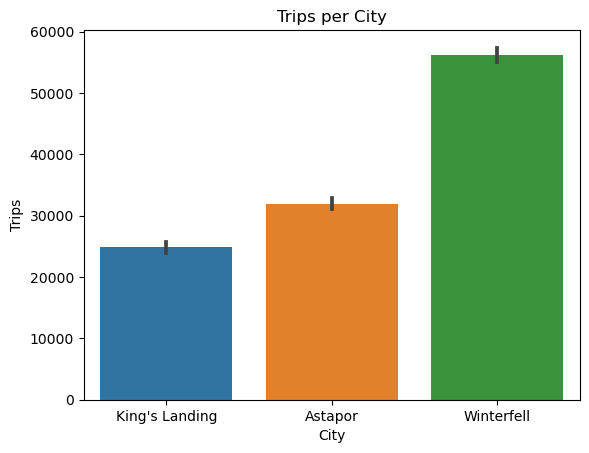

In [78]:
sns.barplot(x='city', y= 'trips_in_first_30_days', data= df, estimator= sum)
plt.title('Trips per City')
plt.xlabel('City')
plt.ylabel('Trips')

`Winterfell` had most active users/riders and generated most trip, followd by `Astapor` and `King's Landing` with the least trips.

Text(0, 0.5, 'Total Trips')

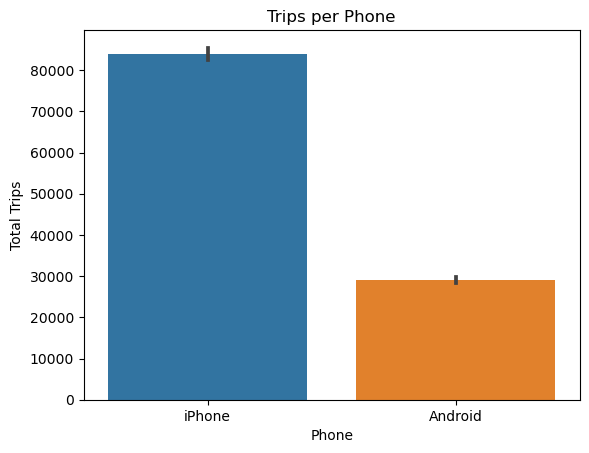

In [79]:
sns.barplot(x='phone', y='trips_in_first_30_days', data= df, estimator= sum)
plt.title('Trips per Phone')
plt.xlabel('Phone')
plt.ylabel('Total Trips')

Regarding the propularity of the `phone` used, iPhone surpasses Android almost 3 fold.

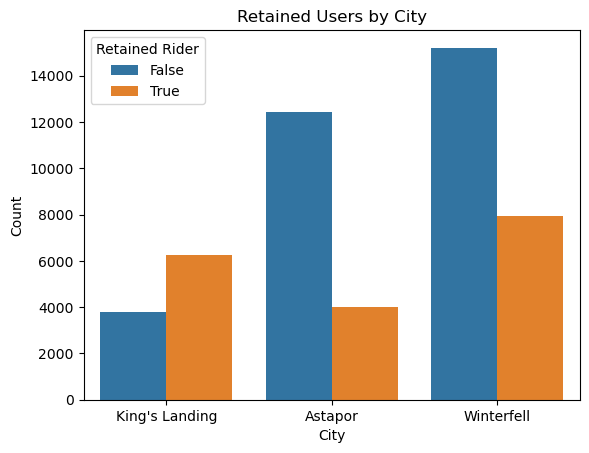

In [54]:
sns.countplot(data= df, x= 'city', hue= 'retained_rider')
plt.title('Retained Users by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.legend(title= 'Retained Rider')

Only `Kind's Landing` had more retained users, while both `Winterfell` and `Astapor` have twice or 3x times, respectively, more churned users.

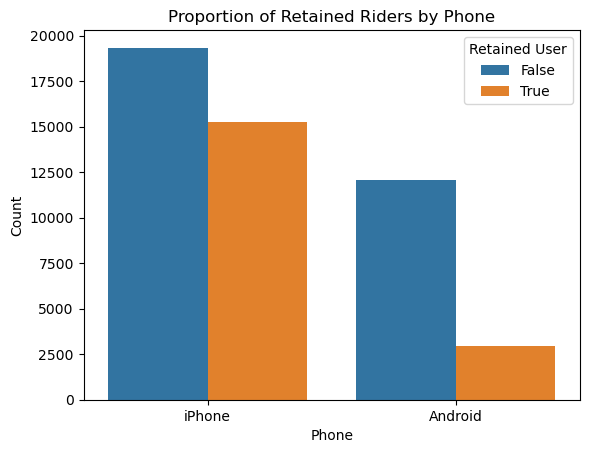

In [55]:
sns.countplot(data=df, x= 'phone', hue= 'retained_rider')
plt.title('Proportion of Retained Riders by Phone')
plt.xlabel('Phone')
plt.ylabel('Count')
plt.legend(title='Retained User')

While both iPhone and Andoid have more churned then retained riders, obviously, the iPhone has superior `retained riders` utilization. Android users are more likely to churn.  

### Modeling

In [110]:
Xx = df.drop(columns=['signup_date', 'last_trip_date', 'retained_rider' ]) # drop these columns
Xx.sample(3)


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
2565,Winterfell,0,4.000000,1.0,iPhone,0.0,False,66.7,1.86,5.0
26544,Winterfell,1,5.000000,1.0,Android,0.0,False,0.0,2.71,5.0
7928,Astapor,1,4.601467,1.0,Android,0.0,False,100.0,2.41,5.0


In [111]:
Xx.columns
'''"Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',\n   'surge_pct', 
'weekday_pct', 'avg_dist', 'avg_rating_by_driver',\n   
'city_Astapor', 'city_King's Landing', 'city_Winterfell',\n  
'phone_Android', 'phone_iPhone', 'ultimate_black_user_False',\n   
'ultimate_black_user_True'],\n    dtype='object')"'''
Xx.shape # (49604, 10)
Xx.head()


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9


In [113]:
# create dummies vars from 'city', 'phone', 'ultimate_black_user' fro the model use
Xx = pd.get_dummies(X, columns= ['city', 'phone', 'ultimate_black_user'])
Xx.sample(5)
# Xx.shape   #(49604, 14)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
24083,7,4.9,1.15,25.0,25.0,2.74,5.0,0,1,0,0,1,0,1
16531,9,4.1,1.01,5.0,55.0,2.03,4.9,0,1,0,0,1,0,1
10917,0,5.0,1.00,0.0,100.0,6.01,4.8,1,0,0,1,0,1,0
33332,3,4.8,1.01,5.6,94.4,14.50,4.8,0,1,0,0,1,0,1
30986,5,5.0,1.00,0.0,100.0,9.78,5.0,0,0,1,0,1,1,0


- for the depending y, convert the boolean feature to numeric

In [115]:
y = pd.DataFrame(np.where(df['retained_rider'] == True, 1, 0), columns= ['retained_rider'])
y.sample(5)

,retained_rider
46735,1
22373,0
9314,1
16471,0
48403,1


In [116]:
X_train, X_test, y_train, y_test = train_test_split(Xx, y, test_size= 0.20, random_state= 12)

In [122]:
model = xgb.XGBClassifier()
params = { 'learning_rate' : (0.04, 0.12),'n_estimators' : [50, 200, 300] }

xgb_cv = GridSearchCV(model, param_grid= params, cv= 6, n_jobs= -1)
xgb_cv.fit(X_train, y_train)
print(xgb_cv.best_params_)

{'learning_rate': 0.04, 'n_estimators': 300}


In [123]:
y_pred = xgb_cv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:\n' , cm)
print('--------------------------------\n')
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[5307  866]
 [1213 2535]]
--------------------------------

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6173
           1       0.75      0.68      0.71      3748

    accuracy                           0.79      9921
   macro avg       0.78      0.77      0.77      9921
weighted avg       0.79      0.79      0.79      9921



The model predicts if a user will be retained with almost 79% accuracy.

<AxesSubplot: >

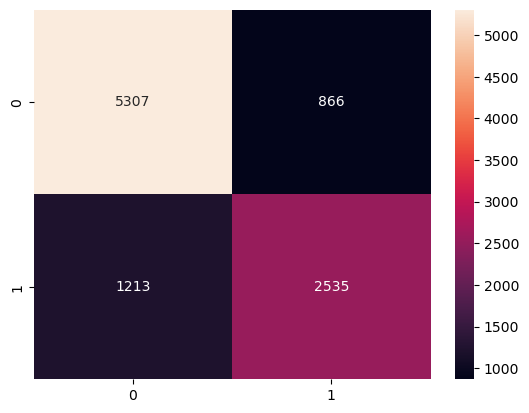

In [124]:
sns.heatmap(cm, annot= True, fmt='g')

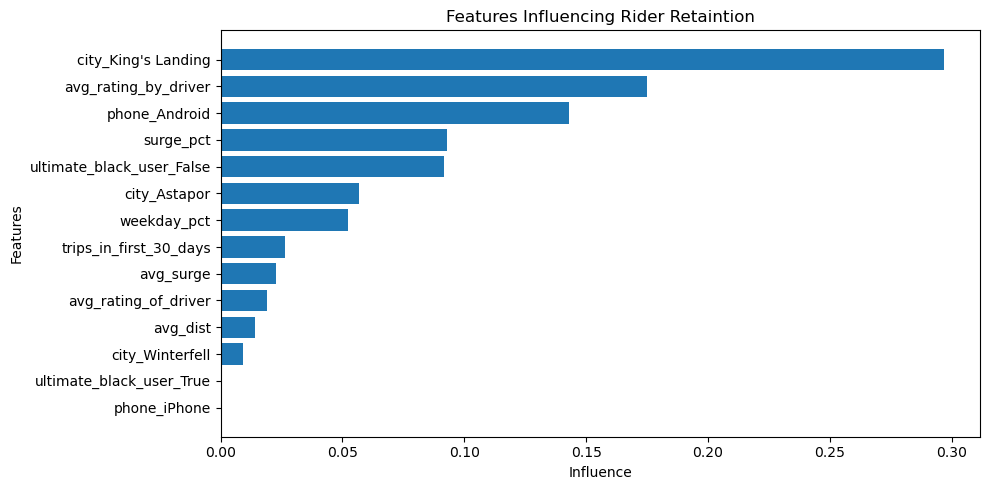

In [127]:
idx = xgb_cv.best_estimator_.feature_importances_.argsort()

plt.subplots(figsize=(10, 5))
plt.barh(X_train.columns[idx], xgb_cv.best_estimator_.feature_importances_[idx])
plt.xlabel('Influence')
plt.ylabel('Features')
plt.title('Features Influencing Rider Retaintion')
plt.tight_layout()

`King's Landing` has the highest influence on rider's retention. While it has the least rides, compared to `Winterfell` or `Astapor` it also has the most commited riders with highest retention rate.
This finding may point to other "extrinsic" factors that may have influence on rider retention: demographic differences, rider's income bracket, race, age, etc.    
Another influential factor is `avg_rating_by_driver`. This may point to a psychological factor, where drivers who rate high, rate probably only those who are pleasant, orderly, leave larger tips, etc, in short, who may show more advanced signs of stability, prestige, priviledge, and if one may extrapolate from that, stable,balanced, preferable and less problematic attitude, which in turn reflects on making choices: more stable people make better choices and therfore, if they had chosen, they may remain longer and be more faitfull to their choice. 
On third place of influence comes `Android`, perhaps because it was influential in more likely to churn a rider then iPhone. That may be due to apps appeal to 'ease of use' and 'accessibilty factor', where iPhone, historically outshines its competition. Possible redevelopment of the `Android` app with those factors in mind would be a viable recomendation. 